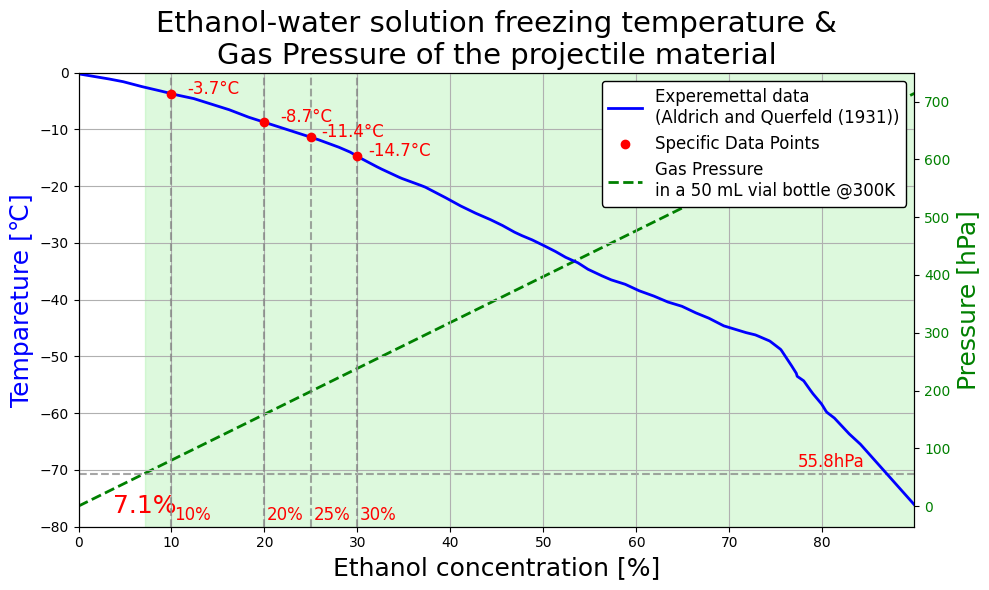

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import math

file_path = 'ethanol_freezingpoint.csv'
material_name = "Ethanol"
ref = "Aldrich and Querfeld (1931)"
concentration_range = np.arange(0, 90, 0.1)
specific_concentrations = np.array([10, 20, 25, 30])  

##
projectile_dia = 0.444 #cm
projectile_height = 0.6 #cm
material_density = 0.789#g/cc
material_molecularweght = 46 #g/mol
room_temp = 300 #K
gas_const = 8.31e3 #Pa L /(K mol)
bottle_vol = 0.050 #l
sat_pre =  55.8 #hPa

# Load the data from the CSV file (assuming it's in the correct path)
ethanol_frez_data = pd.read_csv(file_path, header=None)

# Extract concentration and temperature columns
ethanol_concentration = ethanol_frez_data[0]  # Ethanol concentration
ethanol_temperature = ethanol_frez_data[1]  # Freezing temperature

# # 並べ替えのためにデータをエネルギーに基づいてソート
# def sort_by_energy(energy, cross_section):
#     sorted_indices = np.argsort(energy)  # エネルギーに基づいてインデックスをソート
#     sorted_energy = energy[sorted_indices]
#     sorted_cross_section = cross_section[sorted_indices]
#     return sorted_energy, sorted_cross_section

# # Xylene, Acetone, Ethanol, VUVのデータをソート
# ethanol_temperature = sort_by_energy(ethanol_concentration, ethanol_temperature)

# 平滑化関数（移動平均）
def moving_average(data, window_size):
    if window_size < 2:
        return data  # ウィンドウサイズが1以下ならそのまま返す

    # データの端をリフレクト（反転）して補完
    pad_width = window_size // 2  # 片側のパディングサイズ
    padded_data = np.pad(data, (pad_width, pad_width), mode='edge')  # 端を最も近い値で埋める

    # 平滑化計算
    smoothed_data = np.convolve(padded_data, np.ones(window_size) / window_size, mode='valid')

    return smoothed_data



# Xylene, Acetone, Ethanol, VUVのデータに移動平均を適用
ethanol_temperature = moving_average(ethanol_temperature, window_size=3)
ethanol_concentration = moving_average(ethanol_concentration, window_size=3)


# 調整後のエネルギーを使ってクロスセクションを抽出
def extract_from_adjusted(energy, cross_section, energy_range):
    # 補間関数を定義
    interpolator = interp1d(energy, cross_section, kind='linear', fill_value='extrapolate')
    # エネルギー範囲に対応するクロスセクションの値を抽出
    extracted_cross_section = interpolator(energy_range)
    return extracted_cross_section

# 調整後のエネルギーを基にクロスセクションを抽出
ethanol_temperature = extract_from_adjusted(ethanol_concentration, ethanol_temperature, concentration_range)
index_tmp = np.searchsorted(concentration_range, specific_concentrations)
specific_temperatures = ethanol_temperature[index_tmp]

projectile_mols = np.pi*(0.5*(projectile_dia))**2 *projectile_height*material_density /material_molecularweght* concentration_range/100
gas_pre = projectile_mols*gas_const*room_temp/bottle_vol
index_pre = np.searchsorted(gas_pre, sat_pre*100)
specific_concentration = concentration_range[index_pre]

max_con = max(concentration_range)
min_tmp = math.floor(min(ethanol_temperature/10))*10
# 結果をプロット
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(concentration_range, ethanol_temperature, label='Experemettal data\n({})'.format(ref), color='blue', linestyle='-', linewidth=2)
ax1.set_ylabel('Tempareture [℃]', fontsize=18, color='blue')
ax1.set_xlabel('{} concentration [%]'.format(material_name), fontsize=18)
ax1.set_xlim([0,max_con])
ax1.set_ylim([min_tmp,0])
ax1.tick_params(axis='y')


# ラベルの設定
ax1.grid(True)

# Right y-axis (Gas Pressure)
ax2 = ax1.twinx()
ax2.plot(concentration_range, gas_pre/100, label='Gas Pressure \nin a 50 mL vial bottle @300K', color='green', linestyle='--', linewidth=2)
ax2.set_ylabel('Pressure [hPa]', fontsize=18, color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.axhline(sat_pre, color='gray', linestyle='dashed', alpha=0.7)  # Horizontal line
ax2.annotate(f"{sat_pre:.1f}hPa",
                 (max_con,sat_pre),
                 textcoords="offset points", xytext=(-60,5), ha='center', fontsize=12, color='red',zorder=4)
ax2.axvspan(specific_concentration, 90, color='lightgreen', alpha=0.3, zorder=0)
ax2.annotate(f"{specific_concentration:.1f}%",
                 (specific_concentration,0),
                 textcoords="offset points", xytext=(0,-5), ha='center', fontsize=18, color='red')
# Plot specific points
ax1.scatter(specific_concentrations, specific_temperatures, color='red', label='Specific Data Points', zorder=3)

# Add horizontal and vertical dashed lines
for i in range(len(specific_concentrations)):
    ax1.axvline(x=specific_concentrations[i], color='gray', linestyle='dashed', alpha=0.7)  # Vertical line
    
    # Annotate the specific points
    ax1.annotate(f"{specific_temperatures[i]:.1f}°C",
                 (specific_concentrations[i], specific_temperatures[i]),
                 textcoords="offset points", xytext=(30,0), ha='center', fontsize=12, color='red')
    ax1.annotate(f"{specific_concentrations[i]:.0f}%",
                 (specific_concentrations[i],min_tmp),
                 textcoords="offset points", xytext=(15,5), ha='center', fontsize=12, color='red')
ax1.set_title('{}-water solution freezing temperature &\nGas Pressure of the projectile material'.format(material_name), fontsize=21)
lines_ax1, labels_ax1 = ax1.get_legend_handles_labels()
lines_ax2, labels_ax2 = ax2.get_legend_handles_labels()

ax1.legend(lines_ax1 + lines_ax2, labels_ax1 + labels_ax2, loc="upper right", fontsize=12, framealpha=1, edgecolor="black", facecolor="white", fancybox=True)

ax1.set_zorder(3)
ax2.set_zorder(2)  # Ensure ax2 stays below ax1
ax1.patch.set_visible(False)  # Make ax1 transparent so it doesn't hide ax2


# プロットの表示
fig.tight_layout()
plt.show()


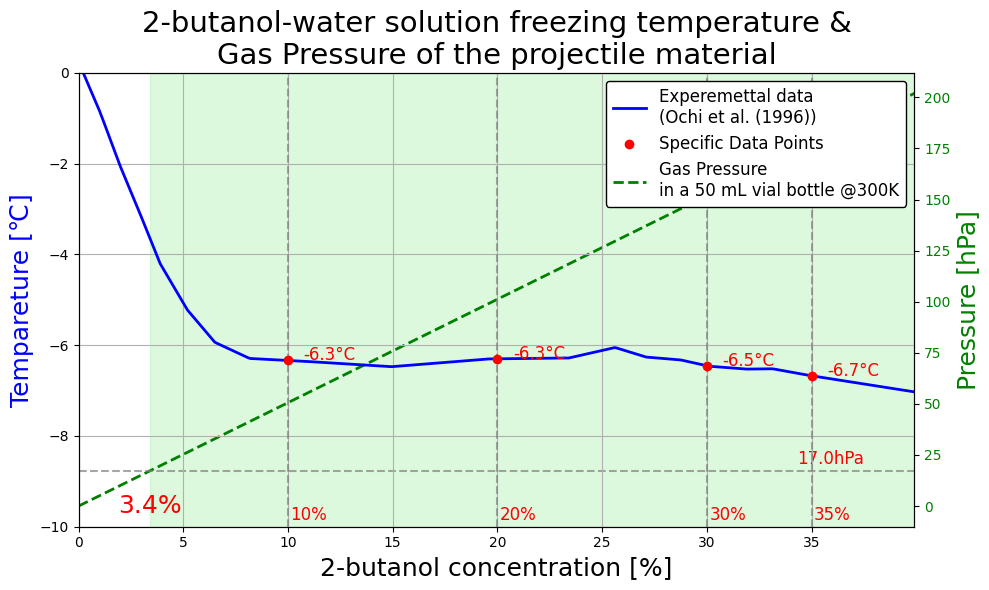

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import math


file_path = '2-butanol_freezingpoint.csv'
material_name = "2-butanol"
ref = "Ochi et al. (1996)"
concentration_range = np.arange(0, 40, 0.1)
specific_concentrations = np.array([10, 20, 30, 35])  

##
projectile_dia = 0.444 #cm
projectile_height = 0.6 #cm
material_density = 0.81#g/cc
material_molecularweght = 74.12 #g/mol
sat_pre =  17 #hPa
room_temp = 300 #K
gas_const = 8.31e3 #Pa L /(K mol)
bottle_vol = 0.050 #l


# Load the data from the CSV file (assuming it's in the correct path)
ethanol_frez_data = pd.read_csv(file_path, header=None)

# Extract concentration and temperature columns
ethanol_concentration = ethanol_frez_data[0]*100  # Ethanol concentration
ethanol_temperature = ethanol_frez_data[1]-273.15  # Freezing temperature

# # 並べ替えのためにデータをエネルギーに基づいてソート
# def sort_by_energy(energy, cross_section):
#     sorted_indices = np.argsort(energy)  # エネルギーに基づいてインデックスをソート
#     sorted_energy = energy[sorted_indices]
#     sorted_cross_section = cross_section[sorted_indices]
#     return sorted_energy, sorted_cross_section

# # Xylene, Acetone, Ethanol, VUVのデータをソート
# ethanol_temperature = sort_by_energy(ethanol_concentration, ethanol_temperature)

# 平滑化関数（移動平均）
def moving_average(data, window_size):
    if window_size < 2:
        return data  # ウィンドウサイズが1以下ならそのまま返す

    # データの端をリフレクト（反転）して補完
    pad_width = window_size // 2  # 片側のパディングサイズ
    padded_data = np.pad(data, (pad_width, pad_width), mode='edge')  # 端を最も近い値で埋める

    # 平滑化計算
    smoothed_data = np.convolve(padded_data, np.ones(window_size) / window_size, mode='valid')

    return smoothed_data



# Xylene, Acetone, Ethanol, VUVのデータに移動平均を適用
ethanol_temperature = moving_average(ethanol_temperature, window_size=3)
ethanol_concentration = moving_average(ethanol_concentration, window_size=3)

# 調整後のエネルギーを使ってクロスセクションを抽出
def extract_from_adjusted(energy, cross_section, energy_range):
    # 補間関数を定義
    interpolator = interp1d(energy, cross_section, kind='linear', fill_value='extrapolate')
    # エネルギー範囲に対応するクロスセクションの値を抽出
    extracted_cross_section = interpolator(energy_range)
    return extracted_cross_section

# 調整後のエネルギーを基にクロスセクションを抽出
ethanol_temperature = extract_from_adjusted(ethanol_concentration, ethanol_temperature, concentration_range)
index_tmp = np.searchsorted(concentration_range, specific_concentrations)
specific_temperatures = ethanol_temperature[index_tmp]

projectile_mols = np.pi*(0.5*(projectile_dia))**2 *projectile_height*material_density /material_molecularweght* concentration_range/100
gas_pre = projectile_mols*gas_const*room_temp/bottle_vol
index_pre = np.searchsorted(gas_pre, sat_pre*100)
specific_concentration = concentration_range[index_pre]

max_con = max(concentration_range)
min_tmp = math.floor(min(ethanol_temperature/10))*10
# 結果をプロット
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(concentration_range, ethanol_temperature, label='Experemettal data\n({})'.format(ref), color='blue', linestyle='-', linewidth=2)
ax1.set_ylabel('Tempareture [℃]', fontsize=18, color='blue')
ax1.set_xlabel('{} concentration [%]'.format(material_name), fontsize=18)
ax1.set_xlim([0,max_con])
ax1.set_ylim([min_tmp,0])
ax1.tick_params(axis='y')


# ラベルの設定
ax1.grid(True)

# Right y-axis (Gas Pressure)
ax2 = ax1.twinx()
ax2.plot(concentration_range, gas_pre/100, label='Gas Pressure\nin a 50 mL vial bottle @300K', color='green', linestyle='--', linewidth=2)
ax2.set_ylabel('Pressure [hPa]', fontsize=18, color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.axhline(sat_pre, color='gray', linestyle='dashed', alpha=0.7)  # Horizontal line
ax2.annotate(f"{sat_pre:.1f}hPa",
                 (max_con,sat_pre),
                 textcoords="offset points", xytext=(-60,5), ha='center', fontsize=12, color='red',zorder=4)
ax2.axvspan(specific_concentration, 90, color='lightgreen', alpha=0.3, zorder=0)
ax2.annotate(f"{specific_concentration:.1f}%",
                 (specific_concentration,0),
                 textcoords="offset points", xytext=(0,-5), ha='center', fontsize=18, color='red')
# Plot specific points
ax1.scatter(specific_concentrations, specific_temperatures, color='red', label='Specific Data Points', zorder=3)

# Add horizontal and vertical dashed lines
for i in range(len(specific_concentrations)):
    ax1.axvline(x=specific_concentrations[i], color='gray', linestyle='dashed', alpha=0.7)  # Vertical line
    
    # Annotate the specific points
    ax1.annotate(f"{specific_temperatures[i]:.1f}°C",
                 (specific_concentrations[i], specific_temperatures[i]),
                 textcoords="offset points", xytext=(30,0), ha='center', fontsize=12, color='red')
    ax1.annotate(f"{specific_concentrations[i]:.0f}%",
                 (specific_concentrations[i],min_tmp),
                 textcoords="offset points", xytext=(15,5), ha='center', fontsize=12, color='red')
ax1.set_title('{}-water solution freezing temperature &\nGas Pressure of the projectile material'.format(material_name), fontsize=21)
lines_ax1, labels_ax1 = ax1.get_legend_handles_labels()
lines_ax2, labels_ax2 = ax2.get_legend_handles_labels()

ax1.legend(lines_ax1 + lines_ax2, labels_ax1 + labels_ax2, loc="upper right", fontsize=12, framealpha=1, edgecolor="black", facecolor="white", fancybox=True)

ax1.set_zorder(3)
ax2.set_zorder(2)  # Ensure ax2 stays below ax1
ax1.patch.set_visible(False)  # Make ax1 transparent so it doesn't hide ax2


# プロットの表示
fig.tight_layout()
plt.show()


In [39]:
specific_temperature

array([ -3.69857204,  -8.72285047, -11.36722441, -14.73866792])